Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Задача — проанализировать данные АB-теста. 

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

А/Б тест проходил с 2022-07-13 по 2022-07-19 включительно. Группа 1 - тест, группа 2 - контроль.

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220820'
}

In [3]:
q = """
SELECT exp_group, 
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-07-13' and '2022-07-19' and exp_group in (1,2)
GROUP BY exp_group, user_id       
"""

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

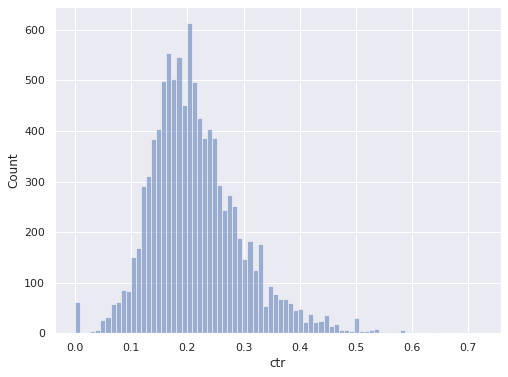

In [7]:
# распределение ctr во второй группе
sns.set(rc={'figure.figsize':(8, 6)})
groups = sns.histplot(data = df[df.exp_group == 1],
                      x='ctr',
                      alpha = 0.5,
                      kde=False
                     )

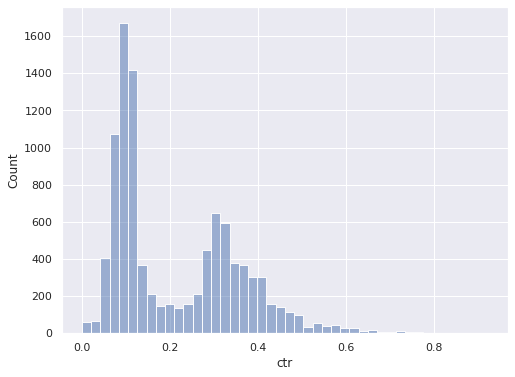

In [8]:
# распределение ctr во второй группе
sns.set(rc={'figure.figsize':(8, 6)})
groups = sns.histplot(data = df[df.exp_group == 2],
                      x='ctr',
                      alpha = 0.5,
                      kde=False
                     )

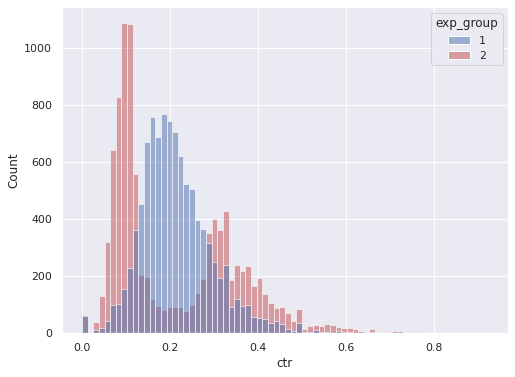

In [9]:
# оба распределения на одном графике

sns.set(rc={'figure.figsize':(8, 6)})
groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['b','r'],
                      alpha = 0.5,
                      kde=False
                     )

Распределение во второй группе сильно скошено, не выполняется условие унимодальности для t-теста. Визуальный анализ показывает: ранее основная доля значений ctr находились около 0.2. С введением нового алгоритма пользователи стали разделились на две "группы", в одной - стали кликать заметно меньше, в другой - заметно больше.

### Метод бакетного преобразования + тест Манна-Уитни

In [10]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-07-13' and '2022-07-19' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [11]:
#тест Манна-Уитни видит различия
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

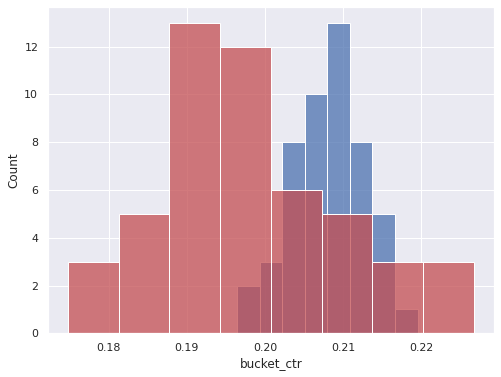

In [12]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)
sns.histplot(df[df.exp_group == 2].bucket_ctr, color='r')

Метод показал наличие значимых различий между группами, тест Манна-Уитни показал разницу в функциях распределения. При этом среднее значение в тестовой группе меньше среднего в контрольной. Применим ещё один метод для того, чтобы сравнить результаты.

### Метод Пуассоновского бутстрепа

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [14]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19' and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [15]:
df = pandahouse.read_clickhouse(q, connection=connection)

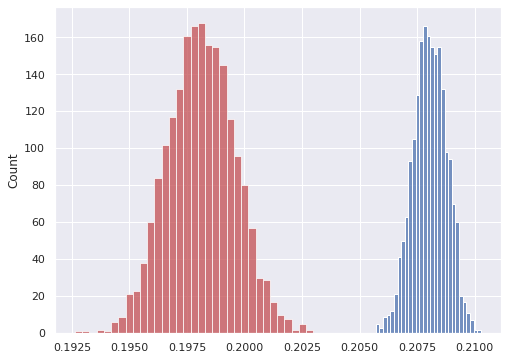

In [16]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2, color='r')

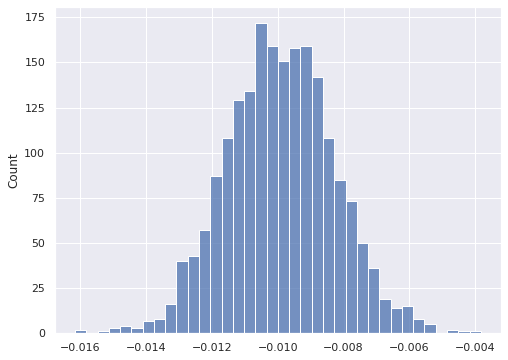

In [17]:
sns.histplot(ctr2 - ctr1)

Метод Пуассоновского бутстрепа также показал значимые различия между группами (распределение разности между ctr2 и ctr1 не пересекает 0), среднее значение в тестовой группе меньше, чем в контрольной. 

### Выводы:


1. Были использованы метод бакетного преобразования + тест Манна-Уитни и метод Пуассоновского бутстрэпа
2. В результате эксперимента были обнаружены значимые различия между группами, при этом новый алгоритм рекомендаций (согласно статистическим тестам) ухудшает показатели целевой метрики ctr, что не даёт достаточно поводов для его внедрения. Визуальный осмотр распределения ctr по пользователям в группах показал: внедрение алгоритма значительно изменило поведение пользователей: одни стали гораздо больше "кликать", другие - гораздо меньше. 
3. Такое поведение пользователей могло быть вызвано резким изменением сценария использования ленты: одни пользователи заинтересовались и начали разбираться в рекомендациях, другие - байкотировали. 
4. На данном этапе нельзя однозначно сказать, что алгоритм плох. Вероятно, проблему можно решить увеличением времени теста для адаптации контрольной группы к этим изменениям (+ надо обратиться к ML-разработчикам для уточнения причин). Кроме того, принятие решений зависит от целей бизнеса и заметное увеличение ctr (пусть и в совокупности со значительным уменьшением) может повлиять положительно на бизнес-цели.